In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel


In [2]:
df = pd.read_csv('sentinlinks.csv')

In [3]:
df.head()

,category,headline,links,abstract,keywords,text,sentiment_score,sentiment_label
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons,143 Miles in 35 Days: Lessons Learned Resting ...,-0.2846,negative
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy,Talking to Yourself: Crazy or Crazy Helpful? T...,0.8074,positive
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug,Crenezumab: Trial Will Gauge Whether Alzheimer...,0.4404,positive
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life,"Oh, What a Difference She Made If you want to ...",0.8402,positive
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods,"Green Superfoods First, the bad news: Soda bre...",0.4664,positive


In [13]:
df.isnull().sum()

category           0
headline           0
links              0
abstract           0
keywords           0
text               0
sentiment_score    0
sentiment_label    0
label              0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47332 entries, 0 to 47331
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         47332 non-null  object 
 1   headline         47332 non-null  object 
 2   links            47332 non-null  object 
 3   abstract         47332 non-null  object 
 4   keywords         47332 non-null  object 
 5   text             47332 non-null  object 
 6   sentiment_score  47332 non-null  float64
 7   sentiment_label  47332 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.9+ MB


In [15]:
#dropping duplicates
print('the number of articles before processing :',len(df))
df.drop_duplicates(subset=['headline','abstract','text'],inplace=True)
print('The number of articles after processing :',len(df))

the number of articles before processing : 47332
The number of articles after processing : 43370


In [16]:
#Getting Headlines with more than 4 words
print('the number of articles before processing :',len(df))
df=df[df['headline'].apply((lambda x: len(x.split())>=4))]
print('The number of articles after processing :',len(df))

the number of articles before processing : 43370
The number of articles after processing : 42098


In [17]:
#Stopword Removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Ishaan
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:

stopword = set(stopwords.words('english'))
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword)
    return text

df['txt_clean'] = df['abstract'].apply(clean_stopwords)

In [20]:
#Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
def porterstemmer(text):
  text = ' '.join([ps.stem(word) for word in text.split() if word in text])
  return text
df['txt_clean'] = df['txt_clean'].apply(porterstemmer)

In [22]:
#Lemmatization
import spacy
nlp = spacy.load('en_core_web_sm')
def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
df['text_clean'] = df['txt_clean'].apply(lemmatization)

Data Visualization

In [23]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

In [24]:
CLASS_NAMES = sorted(list(df.category.unique()))
CLASS_NAMES

['BUSINESS',
 'ENTERTAINMENT',
 'FOOD & DRINK',
 'PARENTING',
 'POLITICS',
 'SPORTS',
 'STYLE & BEAUTY',
 'TRAVEL',
 'WELLNESS',
 'WORLD NEWS']

In [25]:
df[['category','label']].value_counts()

category        label
ENTERTAINMENT   1        4813
WORLD NEWS      9        4796
TRAVEL          7        4737
STYLE & BEAUTY  6        4645
POLITICS        4        4608
FOOD & DRINK    2        4606
WELLNESS        8        4454
PARENTING       3        4199
BUSINESS        0        2729
SPORTS          5        2511
Name: count, dtype: int64

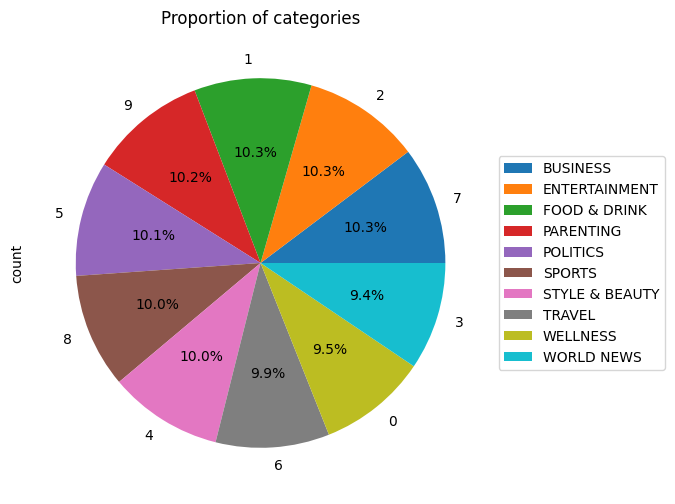

In [11]:
df['label'].value_counts().plot.pie(figsize=(6,6),title="Proportion of categories",autopct='%1.1f%%')
labels=sorted(list(df.category.unique()))
plt.legend(labels,loc='center left',bbox_to_anchor=(1, 0.5))
plt.gca().set_aspect('equal')

In [13]:
df2=df.copy()